<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1">Import</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2">Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3">EDA</a></span><ul class="toc-item"><li><span><a href="#basic-info" data-toc-modified-id="basic-info-3.1">basic info</a></span></li><li><span><a href="#bus_route_id" data-toc-modified-id="bus_route_id-3.2">bus_route_id</a></span></li><li><span><a href="#18~20_ride" data-toc-modified-id="18~20_ride-3.3">18~20_ride</a></span><ul class="toc-item"><li><span><a href="#by-date" data-toc-modified-id="by-date-3.3.1">by date</a></span></li><li><span><a href="#by-day" data-toc-modified-id="by-day-3.3.2">by day</a></span></li><li><span><a href="#by-bus_route_id" data-toc-modified-id="by-bus_route_id-3.3.3">by bus_route_id</a></span></li><li><span><a href="#pivot:-bus_route_id,-date" data-toc-modified-id="pivot:-bus_route_id,-date-3.3.4">pivot: bus_route_id, date</a></span></li></ul></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4">Feature Engineering</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-5">Model</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.1">LightGBM</a></span></li><li><span><a href="#Deep-Learning" data-toc-modified-id="Deep-Learning-5.2">Deep Learning</a></span></li></ul></li></ul></div>

# Import

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
# 한글, 마이너스 깨짐 방지(Windows)
# from matplotlib import rc, font_manager, rcParams
# font=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# rc('font', family=font)
# rcParams['axes.unicode_minus'] = False

In [3]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
pd.set_option('display.width',600)
pd.set_option('precision',10)

plt.style.use('ggplot')

# Load Data

In [4]:
os.listdir('data')

['test.csv',
 'bus_bts.csv',
 '행정_법정동 중심좌표.xlsx',
 'submission_sample.csv',
 'train.csv']

In [5]:
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')

In [6]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [7]:
train2 = train.copy()
test2 = test.copy()

# EDA
## basic info

In [8]:
# data 살펴보기
def data_look(df):
    display(df.info())
    print()
    display(df.isna().sum())
    print()
    display(df.describe())
    print()
    display(df.head())

In [9]:
data_look(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

None

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
count,415423.0000000000,4.1542300000e+05,4.1542300000e+05,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000,415423.0000000000
mean,207711.0000000000,2.6919350951e+07,4.2093112160e+04,33.4203745817,126.5335740682,0.3058930295,0.8296988852,0.8153496557,0.6424752602,0.5996177390,0.5793925709,0.1128704959,0.3448701685,0.5164807919,0.4309222166,0.4080010014,0.4028736974,1.2420954064
std,119922.4347762614,3.9246519870e+06,4.9715040422e+05,0.1079956958,0.1409864972,1.1097659759,2.2551160607,2.3175606424,1.9598439196,1.8859405385,1.9421373911,0.5977142216,1.2791789229,1.6588496973,1.4851235797,1.4128389996,1.4460801899,4.7222869137
min,0.0000000000,4.2700000000e+06,1.0000000000e+00,33.2083500000,126.1650400000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,103855.5000000000,2.3460000000e+07,3.2000000000e+02,33.2910800000,126.4757800000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
50%,207711.0000000000,2.8030000000e+07,1.1300000000e+03,33.4788500000,126.5297700000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
75%,311566.5000000000,3.0030000000e+07,2.2260000000e+03,33.5000200000,126.5758900000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000
max,415422.0000000000,3.2820000000e+07,6.1151010000e+06,33.9636400000,126.9656700000,85.0000000000,94.0000000000,136.0000000000,78.0000000000,124.0000000000,99.0000000000,45.0000000000,66.0000000000,59.0000000000,65.0000000000,52.0000000000,81.0000000000,272.0000000000


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
set(train.columns) -  set(test.columns)

{'18~20_ride'}

In [11]:
for col in train.columns:
    print(f'colomn: {col}')
    print(f'unique 수: {train[col].nunique()}')
    print()

colomn: id
unique 수: 415423

colomn: date
unique 수: 30

colomn: bus_route_id
unique 수: 613

colomn: in_out
unique 수: 2

colomn: station_code
unique 수: 3563

colomn: station_name
unique 수: 1961

colomn: latitude
unique 수: 3278

colomn: longitude
unique 수: 3446

colomn: 6~7_ride
unique 수: 47

colomn: 7~8_ride
unique 수: 80

colomn: 8~9_ride
unique 수: 78

colomn: 9~10_ride
unique 수: 66

colomn: 10~11_ride
unique 수: 66

colomn: 11~12_ride
unique 수: 69

colomn: 6~7_takeoff
unique 수: 35

colomn: 7~8_takeoff
unique 수: 51

colomn: 8~9_takeoff
unique 수: 53

colomn: 9~10_takeoff
unique 수: 46

colomn: 10~11_takeoff
unique 수: 47

colomn: 11~12_takeoff
unique 수: 55

colomn: 18~20_ride
unique 수: 170



In [12]:
for col in test.columns:
    print(f'column: {col}')
    print(f'unique 수: {test[col].nunique()}')
    print()

column: id
unique 수: 228170

column: date
unique 수: 16

column: bus_route_id
unique 수: 601

column: in_out
unique 수: 2

column: station_code
unique 수: 3505

column: station_name
unique 수: 1954

column: latitude
unique 수: 3230

column: longitude
unique 수: 3386

column: 6~7_ride
unique 수: 40

column: 7~8_ride
unique 수: 62

column: 8~9_ride
unique 수: 70

column: 9~10_ride
unique 수: 66

column: 10~11_ride
unique 수: 56

column: 11~12_ride
unique 수: 64

column: 6~7_takeoff
unique 수: 28

column: 7~8_takeoff
unique 수: 48

column: 8~9_takeoff
unique 수: 45

column: 9~10_takeoff
unique 수: 48

column: 10~11_takeoff
unique 수: 47

column: 11~12_takeoff
unique 수: 51



- train의 bus_route_id 수가 test보다 많음

## bus_route_id

In [13]:
cnt = 0
for row in train['bus_route_id'].unique():
    if row not in test['bus_route_id'].unique():
        print(row)
        cnt += 1
print(cnt)

21550000
27140000
28780000
29480000
30280000
27600000
28800000
28830000
22390000
30210000
21590000
23630000
30350000
31040000
21160000
27050000
29940000
29570000
31220000
28640000
29170000
30950000
21860000
31380000
29550000
30360000
32090000
23540000
27040000
30080000
30


In [14]:
cnt = 0
for row in test['bus_route_id'].unique():
    if row not in train['bus_route_id'].unique():
        print(row)
        cnt += 1
print(cnt)

21510000
29850000
32780000
22590000
28550000
29650000
32410000
23660000
30320000
29230000
30800000
29180000
20020000
26260000
30990000
8880000
28470000
32790000
18


- train에 없는 bus_route_id가 test에 포함되어 있음

## 18~20_ride
### by date

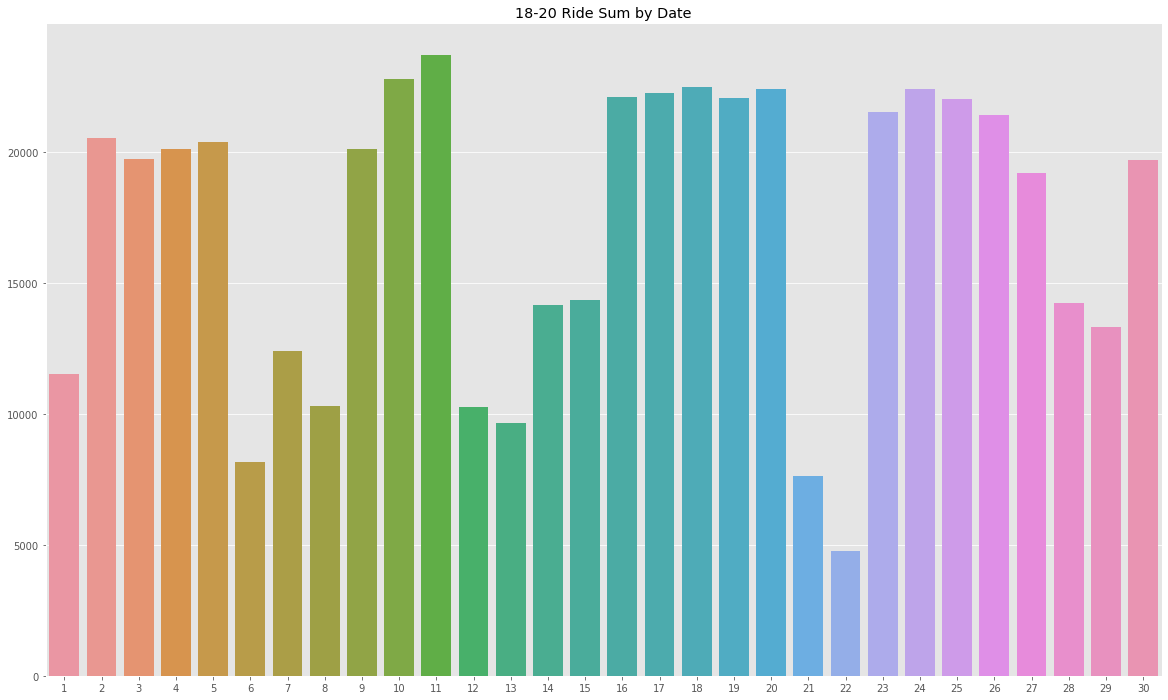

In [15]:
# 일자별 퇴근 시간 탑승객 수 합계
date_sum = train.groupby('date')['18~20_ride'].sum()
plt.figure(figsize=(20,12))
sns.barplot(x=np.arange(1,31), y=date_sum.values) # palette 색상 설정 가능
plt.title('18-20 Ride Sum by Date')
plt.show()

### by day

In [16]:
# 요일 컬럼 생성
train2['date'] = pd.to_datetime(train2['date'])
train2['day'] = train2['date'].dt.weekday

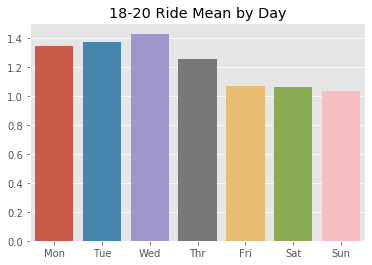

In [17]:
# 요일별 퇴근 시간 탑승객 수 평균
day_mean = train2.groupby('day')['18~20_ride'].mean()
sns.barplot(x='Mon Tue Wed Thr Fri Sat Sun'.split(), y=day_mean.values)
plt.title('18-20 Ride Mean by Day')
plt.show()

### by bus_route_id

In [18]:
# 버스 루트별 퇴근 시간 탑승객 수 평균
route_mean = train.groupby('bus_route_id')['18~20_ride'].mean()
route_mean = route_mean.sort_values(ascending=False)
route_mean[:30]

bus_route_id
23620000    16.2450000000
23610000    14.9954407295
23580000    13.7259380098
23570000    12.3216560510
22530000     6.1233875491
29990000     6.0882352941
22520000     5.7969543147
32360000     4.9548611111
8170000      4.9490084986
23000000     4.7592592593
31220000     4.6000000000
32340000     4.5889212828
25000000     4.4146455224
32350000     4.3258594918
23320000     4.3124087591
23450000     4.1472803347
23280000     4.1403940887
23500000     4.0564866543
24020000     4.0253878702
23220000     4.0098314607
21000000     3.9864406780
21520000     3.9356872636
25010000     3.8368495077
24030000     3.8152096660
21480000     3.7119496855
23330000     3.6184122748
21290000     3.5169811321
23020000     3.5059652928
28640000     3.5000000000
21010000     3.4731707317
Name: 18~20_ride, dtype: float64

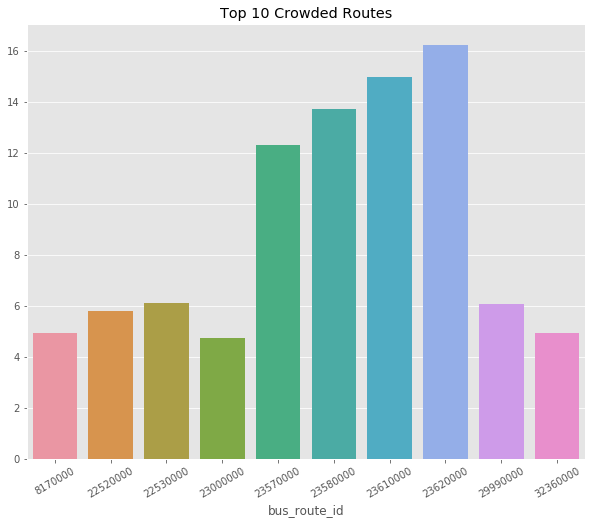

In [19]:
# 평균 승객 가장 많은 루트 Top 10
plt.figure(figsize=(10,8))
sns.barplot(x=route_mean.index[:10], y=route_mean.values[:10])
plt.xticks(rotation=30)
plt.title('Top 10 Crowded Routes')
plt.show()

In [20]:
# 승객이 많고 id가 비슷한 두 루트 비교
train[train['bus_route_id'] == 23620000]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
3634,3634,2019-09-01,23620000,시내,117,남국사,33.46049,126.54979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3635,3635,2019-09-01,23620000,시내,119,죽성마을입구,33.46313,126.54910,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
3636,3636,2019-09-01,23620000,시내,121,제주대학교병원,33.46909,126.54739,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0
3637,3637,2019-09-01,23620000,시내,123,인다마을,33.47145,126.54540,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,3.0,5.0,0.0
3638,3638,2019-09-01,23620000,시내,125,아라주공아파트,33.47366,126.54542,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,8.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403990,403990,2019-09-30,23620000,시내,3272,고산동산(아라방면),33.49600,126.53228,0.0,6.0,13.0,13.0,19.0,12.0,0.0,2.0,1.0,8.0,13.0,9.0,5.0
403991,403991,2019-09-30,23620000,시내,3274,제주지방법원(아라방면),33.49311,126.53509,0.0,2.0,6.0,5.0,13.0,5.0,2.0,4.0,2.0,3.0,7.0,7.0,13.0
403992,403992,2019-09-30,23620000,시내,3276,제주중앙여자고등학교(아라방면),33.48941,126.53864,0.0,3.0,6.0,7.0,8.0,1.0,0.0,1.0,2.0,6.0,2.0,8.0,10.0
403993,403993,2019-09-30,23620000,시내,3278,제주여자중고등학교(아라방면),33.48486,126.54293,1.0,0.0,9.0,0.0,8.0,1.0,0.0,6.0,6.0,3.0,5.0,6.0,2.0


In [21]:
train[train['bus_route_id'] == 23610000]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
3591,3591,2019-09-01,23610000,시내,116,남국사,33.46215,126.54958,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3592,3592,2019-09-01,23610000,시내,120,제주대학교병원,33.46916,126.54777,2.0,2.0,1.0,4.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3593,3593,2019-09-01,23610000,시내,122,인다마을,33.47064,126.54582,9.0,3.0,8.0,8.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3594,3594,2019-09-01,23610000,시내,124,아라주공아파트,33.47308,126.54569,4.0,3.0,11.0,20.0,4.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
3595,3595,2019-09-01,23610000,시내,131,아라동주민센터,33.47590,126.54490,2.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403950,403950,2019-09-30,23610000,시내,3273,고산동산(광양방면),33.49554,126.53291,3.0,5.0,11.0,10.0,16.0,12.0,0.0,4.0,2.0,2.0,2.0,2.0,22.0
403951,403951,2019-09-30,23610000,시내,3275,제주지방법원(광양방면),33.49363,126.53476,5.0,19.0,11.0,22.0,14.0,18.0,0.0,2.0,0.0,6.0,2.0,0.0,24.0
403952,403952,2019-09-30,23610000,시내,3277,제주중앙여자고등학교(광양방면),33.48902,126.53920,2.0,7.0,7.0,12.0,9.0,8.0,0.0,1.0,3.0,1.0,4.0,0.0,21.0
403953,403953,2019-09-30,23610000,시내,3279,제주여자중고등학교(광양방면),33.48520,126.54289,4.0,8.0,9.0,6.0,5.0,5.0,0.0,3.0,0.0,1.0,0.0,1.0,24.0


In [22]:
a = train[train['bus_route_id'] == 23620000]['station_code'].unique()
b = train[train['bus_route_id'] == 23610000]['station_code'].unique()
print(len(a))
print(len(b))

54
72


In [23]:
cnt = 0
for row in a:
    if row in b:
        print(row)
        cnt += 1
cnt

123
125
185
188
206
269
272
284
286
304
306
308
319
320
323
324
358
360
361
431
433
443
637
3270
3272
3274
3276
3278
3280
120
1355
270
283
299
3271
3275
201
325
124
3273
3277
3279


42

- 평균 승객이 많은 1, 2위 루트의 정류장 42곳이 겹침

### pivot: bus_route_id, date

In [24]:
# 버스 루트, 일자별 퇴근 시간 탑승객 수 합계 
route_date_sum = train.groupby(['bus_route_id', 'date'])['18~20_ride'].sum().reset_index()
route_date_sum

,bus_route_id,date,18~20_ride
0,4270000,2019-09-01,79.0
1,4270000,2019-09-02,92.0
2,4270000,2019-09-03,65.0
3,4270000,2019-09-04,58.0
4,4270000,2019-09-05,74.0
...,...,...,...
15632,32820000,2019-09-26,0.0
15633,32820000,2019-09-27,0.0
15634,32820000,2019-09-28,0.0
15635,32820000,2019-09-29,0.0


In [25]:
pivot = route_date_sum.pivot_table('18~20_ride', index='date', columns='bus_route_id').fillna(0.0)
pivot

bus_route_id,4270000,4280000,7990000,8170000,8180000,17010000,20010000,20040000,20050000,21000000,21010000,21020000,21040000,21070000,21080000,21090000,21100000,21110000,21120000,21150000,21160000,21180000,21200000,21220000,21230000,21270000,21290000,21300000,21310000,21330000,21340000,21350000,21360000,21370000,21390000,21400000,21410000,21420000,21430000,21440000,21450000,21460000,21470000,21480000,21500000,21520000,21540000,21550000,21570000,21580000,...,32190000,32200000,32210000,32220000,32230000,32240000,32250000,32260000,32270000,32280000,32290000,32310000,32320000,32330000,32340000,32350000,32360000,32370000,32380000,32390000,32400000,32420000,32460000,32470000,32480000,32490000,32500000,32510000,32520000,32550000,32560000,32570000,32580000,32590000,32610000,32620000,32630000,32640000,32660000,32670000,32680000,32690000,32700000,32710000,32730000,32740000,32760000,32770000,32810000,32820000
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-01,79.0,80.0,0.0,118.0,6.0,0.0,1.0,0.0,0.0,63.0,69.0,0.0,0.0,0.0,38.0,21.0,13.0,13.0,0.0,0.0,0.0,20.0,0.0,21.0,24.0,21.0,22.0,8.0,0.0,0.0,0.0,10.0,1.0,0.0,7.0,4.0,45.0,84.0,33.0,26.0,0.0,5.0,0.0,95.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,6.0,52.0,0.0,79.0,53.0,27.0,12.0,10.0,0.0,7.0,0.0,2.0,10.0,12.0,16.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,14.0,1.0,3.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-02,92.0,54.0,0.0,49.0,17.0,0.0,5.0,0.0,0.0,92.0,56.0,0.0,0.0,0.0,42.0,28.0,20.0,9.0,0.0,0.0,0.0,29.0,0.0,18.0,19.0,22.0,27.0,23.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,1.0,46.0,59.0,19.0,7.0,0.0,8.0,0.0,114.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,35.0,107.0,0.0,134.0,115.0,70.0,23.0,17.0,8.0,11.0,0.0,2.0,8.0,6.0,27.0,10.0,0.0,0.0,0.0,0.0,16.0,0.0,26.0,4.0,18.0,12.0,7.0,13.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-03,65.0,69.0,0.0,55.0,10.0,0.0,16.0,0.0,0.0,60.0,70.0,0.0,0.0,0.0,45.0,24.0,29.0,24.0,0.0,0.0,0.0,13.0,0.0,18.0,18.0,14.0,12.0,11.0,0.0,0.0,0.0,9.0,6.0,0.0,7.0,6.0,50.0,46.0,8.0,17.0,0.0,4.0,0.0,99.0,0.0,88.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,32.0,108.0,0.0,117.0,137.0,51.0,10.0,20.0,16.0,15.0,0.0,5.0,8.0,9.0,31.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,21.0,9.0,14.0,3.0,19.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-04,58.0,90.0,0.0,69.0,12.0,1.0,8.0,0.0,0.0,64.0,74.0,0.0,0.0,0.0,33.0,21.0,33.0,13.0,0.0,0.0,0.0,36.0,0.0,14.0,8.0,11.0,32.0,11.0,0.0,0.0,0.0,8.0,2.0,0.0,9.0,5.0,46.0,57.0,17.0,14.0,0.0,3.0,1.0,102.0,0.0,96.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,5.0,0.0,0.0,0.0,21.0,127.0,0.0,123.0,141.0,69.0,17.0,10.0,8.0,27.0,0.0,6.0,7.0,13.0,24.0,8.0,0.0,0.0,0.0,0.0,13.0,0.0,19.0,6.0,21.0,4.0,12.0,11.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-05,74.0,61.0,0.0,52.0,31.0,0.0,10.0,0.0,0.0,78.0,80.0,0.0,0.0,0.0,36.0,23.0,27.0,20.0,0.0,0.0,0.0,13.0,0.0,13.0,30.0,21.0,44.0,15.0,0.0,0.0,0.0,1.0,1.0,0.0,10.0,9.0,42.0,94.0,17.0,28.0,0.0,6.0,4.0,99.0,0.0,93.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,36.0,128.0,0.0,179.0,60.0,60.0,16.0,16.0,10.0,16.0,0.0,4.0,12.0,3.0,23.0,11.0,0.0,0.0,0.0,0.0,12.0,0.0,22.0,4.0,7.0,2.0,18.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-06,29.0,43.0,0.0,48.0,6.0,0.0,2.0,0.0,0.0,65.0,12.0,0.0,0.0,0.0,16.0,8.0,13.0,3.0,0.0,0.0,0.0,3.0,0.0,15.0,7.0,6.0,14.0,2.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,1.0,31.0,9.0,11.0,2.0,0.0,3.0,0.0,34.0,0.0,54.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,69.0,0.0,64.0,21.0,15.0,7.0,4.0,5.0,6.0,0.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,4.0,1.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-07,59.0,45.0,0.0,12.0,15.0,0.0,0.0,0.0,0.0,54.0,29.0,0.0,0.0,0.0,12.0,8.0,14.0,2.0,0.0,0.0,0.0,4.0,0.0,10.0,6.0,7.0,12.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,38.0,28.0,3.0,6.0,0.0,1.0,0.0,40.0,0.0,33.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,43.0,35.0,

In [26]:
pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
bus_route_id,,,,,,,,
4270000,30.0,80.3000000000,26.6667169540,19.0,65.25,79.0,93.75,159.0
4280000,30.0,65.0666666667,15.7347262193,28.0,54.00,67.0,74.50,93.0
7990000,30.0,0.0000000000,0.0000000000,0.0,0.00,0.0,0.00,0.0
8170000,30.0,58.2333333333,27.1517870541,12.0,45.50,55.0,72.75,118.0
8180000,30.0,18.8666666667,14.1536722013,1.0,10.25,16.0,25.75,77.0
17010000,30.0,0.1333333333,0.4341724855,0.0,0.00,0.0,0.00,2.0
20010000,30.0,6.1666666667,5.1063404355,0.0,2.00,5.0,8.75,17.0
20040000,30.0,0.0333333333,0.1825741858,0.0,0.00,0.0,0.00,1.0
20050000,30.0,0.0000000000,0.0000000000,0.0,0.00,0.0,0.00,0.0


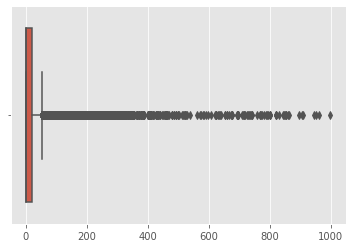

In [27]:
sns.boxplot(x=pivot.columns, data=pivot)

# Feature Engineering

In [28]:
# train, test 합치기
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [29]:
# datetime
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.weekday
# 평일, 주말
data.loc[data['day'] < 5, 'day'] = 0
data.loc[data['day'] >= 5, 'day'] = 1
# 공휴일
holidays = pd.to_datetime(["2019-09-12", "2019-09-13", "2019-09-14", "2019-10-03", "2019-10-09"])
data.loc[data['date'].isin(holidays), 'day'] = 2

In [30]:
# 시내, 시외
data['in_out'] =  data['in_out'].map({'시내': 0, '시외': 1})

In [31]:
# 시간대를 2시간 간격으로 통합
data['6~8_ride'] = data.pop('6~7_ride') + data.pop('7~8_ride')
data['8~10_ride'] = data.pop('8~9_ride') + data.pop('9~10_ride')
data['10~12_ride'] = data.pop('10~11_ride') + data.pop('11~12_ride')

data['6~8_takeoff'] = data.pop('6~7_takeoff') + data.pop('7~8_takeoff')
data['8~10_takeoff'] = data.pop('8~9_takeoff') + data.pop('9~10_takeoff')
data['10~12_takeoff'] = data.pop('10~11_takeoff') + data.pop('11~12_takeoff')

In [32]:
# 정류장 코드 라벨인코딩
data['station_code'] = data['station_code'].astype(str)
le = LabelEncoder()
encoded = le.fit_transform(data['station_code'])
data['station_code'] = encoded

In [33]:
data = data.drop(['bus_route_id', 'date', 'id', 'station_name', 'latitude', 'longitude'], axis=1)

In [34]:
trainset = data.dropna()  # 타겟 컬럼이 비어있는 test data 삭제
testset = data.iloc[len(train):]

In [35]:
x_train = trainset.drop('18~20_ride', axis=1)
y_train = trainset['18~20_ride']

In [36]:
x_test = testset.dropna(axis=1)  # 비어있는 타겟 컬럼 삭제

# Model
## LightGBM

In [37]:
lgb = lgb.LGBMRegressor(
    n_estimators=500,
    random_state=123
)

In [38]:
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
pred = lgb.predict(x_test)

In [41]:
submission_path = os.path.join('data', 'submission_sample.csv')
submission = pd.read_csv(submission_path)
submission['18~20_ride'] = pred
submission.to_csv('./submission/lgb_500.csv', index=False)

## Deep Learning

In [43]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=[len(x_train.columns)]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

In [44]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mse', 'mae']
)

In [45]:
model.fit(x_train.values,
         y_train.values,
         batch_size=256,
         validation_split=0.2,
         epochs=20)

Epoch 1/20
1299/1299 [==============================] - 1s 902us/step - loss: 123.6119 - mse: 123.6119 - mae: 2.7799 - val_loss: 9.5773 - val_mse: 9.5773 - val_mae: 1.1522
Epoch 2/20
1299/1299 [==============================] - 1s 818us/step - loss: 14.6775 - mse: 14.6775 - mae: 1.7125 - val_loss: 11.9643 - val_mse: 11.9643 - val_mae: 1.8490
Epoch 3/20
1299/1299 [==============================] - 1s 822us/step - loss: 17.6990 - mse: 17.6990 - mae: 2.2046 - val_loss: 9.6634 - val_mse: 9.6634 - val_mae: 1.2495
Epoch 4/20
1299/1299 [==============================] - 1s 817us/step - loss: 17.6121 - mse: 17.6121 - mae: 2.1889 - val_loss: 31.2612 - val_mse: 31.2612 - val_mae: 4.2719
Epoch 5/20
1299/1299 [==============================] - 1s 825us/step - loss: 17.2276 - mse: 17.2276 - mae: 2.1450 - val_loss: 37.0682 - val_mse: 37.0682 - val_mae: 4.7398
Epoch 6/20
1299/1299 [==============================] - 1s 825us/step - loss: 17.8951 - mse: 17.8951 - mae: 2.1386 - val_loss: 25.0565 - val_m